In [1]:
import torch
from torch import nn
from load_mnist import load_mnist
import matplotlib.pyplot as plt
import numpy as np
from time import time
np.random.seed(0)

## 1.1 Multi Layer Fully Connected Network

In [17]:
def training_curve_plot(title, train_losses, test_losses, train_accuracy, test_accuracy):
    """ 
    convenience function for plotting train and test loss and accuracy
    """
    lg=13
    md=8
    sm=7
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=md)
    x = range(1, len(train_losses)+1)
    axs[0].plot(x, train_losses, label=f'Final train loss: {train_losses[-1]:.4f}')
    axs[0].plot(x, test_losses, label=f'Final test loss: {test_losses[-1]:.4f}')
    axs[0].set_title('Losses', fontsize=md)
    axs[0].set_xlabel('Iteration', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {train_accuracy[-1]:.4f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {test_accuracy[-1]:.4f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Iteration', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

In [18]:
#Network architecture
# Implement a 2-layer neural network
class Net(nn.Module):
    """
    2 layer neural network with relu acitvation functions
    """
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        """
        Initialize the model by setting up the two linear layers.
        Args:
            input_size: The number of input features in your training/test data
            hidden_size_1: The size of the hidden layer in the network
            hidden_size_2: The size of the hidden layer in the network
            num_classes: The size of the output layer, i.e. the number of classes
        """
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, num_classes)
        
    def forward(self, x):
        """
        Perform a forward pass of our model on input features, x.
        Args:
            x: A batch of input features of size (batch_size, input_size)
        """
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
       
        return out

In [4]:
#Load MNIST dataset
x_train, y_train, x_test, y_test = load_mnist()

In [19]:

bz = 64



# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
X_train_3Dtensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1, 28, 28)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
X_train_3Dtensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1, 28, 28)
Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_set = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
test_set = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=bz, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=bz, shuffle=False)

train_3d = torch.utils.data.TensorDataset(X_train_3Dtensor, Y_train_tensor)
train_loader_3d = torch.utils.data.DataLoader(train_3d, batch_size=bz, shuffle=True)
test_3d = torch.utils.data.TensorDataset(X_train_3Dtensor, Y_train_tensor)
test_loader_3d = torch.utils.data.DataLoader(test_3d, batch_size=bz, shuffle=False)

In [20]:
def train_network(model: nn.Module, criteria: nn.Module, 
                  optimizer: torch.optim.Optimizer, num_epochs: int, train_loader: torch.utils.data.DataLoader, 
                  test_loader: torch.utils.data.DataLoader, device: torch.device, model_name: str, lr: float) -> None:
    """
    Train a neural network model
    
    Args:
        model: The neural network model to be trained
        criteria: The loss function
        optimizer: The optimizer
        num_epochs: The number of epochs to train the model
        train_loader: The training data loader
        test_loader: The test data loader
        device: The device to run the model on
    """
    train_costs = []
    test_costs = []
    train_accuracy = []
    test_accuracy = []
    start = time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            
            outputs = model(images)
            loss = criteria(outputs, torch.argmax(labels, dim=1))
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
        train_costs.append(train_loss / len(train_loader))
        train_accuracy.append(100 * correct / total)
    
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criteria(outputs, torch.argmax(labels, dim=1))
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
            
            test_costs.append(test_loss / len(test_loader))
            test_accuracy.append(100 * correct / total)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_costs[-1]:.4f}, Test Loss: {test_costs[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}%, Test Accuracy: {test_accuracy[-1]:.4f}%')
    total = time() - start
    
    plot_title = model_name + " - lr: " + str(lr) + " - Total Time: " + str(total // 60) + "min " + str(total % 60) + "s " + "-Epochs: " + str(num_epochs)
    return plot_title, train_costs, test_costs, train_accuracy, test_accuracy
    
            
    

In [21]:
#Hyperparameters
models = {}
input_size = 28*28
hidden_size_1 = 512
hidden_size_2 = 256
num_classes = 10
num_epochs = 50
learning_rate = 0.01

Epoch 1/50, Train Loss: 1.6443, Test Loss: 0.7177, Train Accuracy: 62.7800%, Test Accuracy: 82.8900%
Epoch 2/50, Train Loss: 0.5246, Test Loss: 0.4083, Train Accuracy: 86.3417%, Test Accuracy: 88.5300%
Epoch 3/50, Train Loss: 0.3819, Test Loss: 0.3401, Train Accuracy: 89.2833%, Test Accuracy: 90.3200%
Epoch 4/50, Train Loss: 0.3339, Test Loss: 0.3060, Train Accuracy: 90.5533%, Test Accuracy: 91.2700%
Epoch 5/50, Train Loss: 0.3046, Test Loss: 0.2842, Train Accuracy: 91.2717%, Test Accuracy: 91.7000%
Epoch 6/50, Train Loss: 0.2815, Test Loss: 0.2632, Train Accuracy: 91.9233%, Test Accuracy: 92.5200%
Epoch 7/50, Train Loss: 0.2619, Test Loss: 0.2498, Train Accuracy: 92.4650%, Test Accuracy: 93.0000%
Epoch 8/50, Train Loss: 0.2448, Test Loss: 0.2372, Train Accuracy: 93.0283%, Test Accuracy: 93.2900%
Epoch 9/50, Train Loss: 0.2298, Test Loss: 0.2216, Train Accuracy: 93.4183%, Test Accuracy: 93.5900%
Epoch 10/50, Train Loss: 0.2159, Test Loss: 0.2076, Train Accuracy: 93.8883%, Test Accuracy

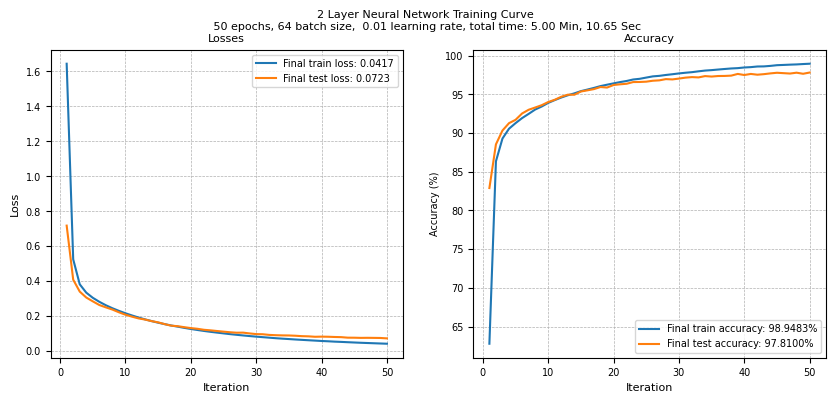

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model_name = '2 Layer Neural Network'
models["2lnn"] = train_network(model, criteria, optimizer, num_epochs, train_loader, test_loader, device, model_name, learning_rate)

## 1.2 Multi-Layer CNN


In [22]:
class mlconvnet(nn.Module):
    def __init__(self):
        super(mlconvnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x


Epoch 1/50, Train Loss: 1.2252, Test Loss: 0.3848, Train Accuracy: 64.6467%, Test Accuracy: 87.8450%
Epoch 2/50, Train Loss: 0.2830, Test Loss: 0.2325, Train Accuracy: 91.3367%, Test Accuracy: 92.6883%
Epoch 3/50, Train Loss: 0.1871, Test Loss: 0.1575, Train Accuracy: 94.4183%, Test Accuracy: 95.2633%
Epoch 4/50, Train Loss: 0.1394, Test Loss: 0.1196, Train Accuracy: 95.7817%, Test Accuracy: 96.3717%
Epoch 5/50, Train Loss: 0.1121, Test Loss: 0.1029, Train Accuracy: 96.6250%, Test Accuracy: 96.8033%
Epoch 6/50, Train Loss: 0.0960, Test Loss: 0.0925, Train Accuracy: 97.1267%, Test Accuracy: 97.2233%
Epoch 7/50, Train Loss: 0.0851, Test Loss: 0.1177, Train Accuracy: 97.4333%, Test Accuracy: 96.1817%
Epoch 8/50, Train Loss: 0.0770, Test Loss: 0.0687, Train Accuracy: 97.6483%, Test Accuracy: 97.8883%
Epoch 9/50, Train Loss: 0.0703, Test Loss: 0.0659, Train Accuracy: 97.8417%, Test Accuracy: 98.0367%
Epoch 10/50, Train Loss: 0.0656, Test Loss: 0.0609, Train Accuracy: 98.0000%, Test Accuracy

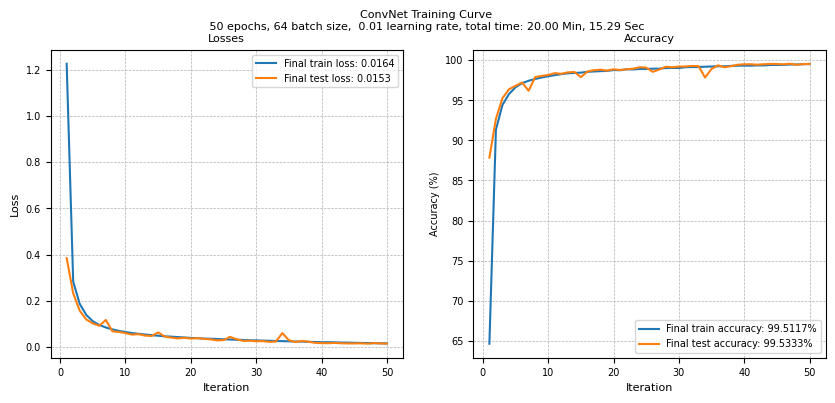

In [10]:
# Create a multi layer conv net
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
convenet = mlconvnet().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(convenet.parameters(), lr=learning_rate)
name = 'CNN'
models["cnn"] = train_network(convenet, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)

## 1.3 Swap orders of max pool and activation function

In [11]:
class mlconvnetorderwap(nn.Module):
    def __init__(self):
        super(mlconvnetorderwap, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()
       
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
        

        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

Epoch 1/50, Train Loss: 1.1302, Test Loss: 0.3655, Train Accuracy: 65.5017%, Test Accuracy: 88.9667%
Epoch 2/50, Train Loss: 0.2949, Test Loss: 0.2368, Train Accuracy: 91.0783%, Test Accuracy: 93.0967%
Epoch 3/50, Train Loss: 0.2012, Test Loss: 0.1704, Train Accuracy: 94.0433%, Test Accuracy: 94.9533%
Epoch 4/50, Train Loss: 0.1505, Test Loss: 0.1329, Train Accuracy: 95.5150%, Test Accuracy: 96.0933%
Epoch 5/50, Train Loss: 0.1216, Test Loss: 0.1253, Train Accuracy: 96.3683%, Test Accuracy: 96.0600%
Epoch 6/50, Train Loss: 0.1040, Test Loss: 0.0930, Train Accuracy: 96.8783%, Test Accuracy: 97.2400%
Epoch 7/50, Train Loss: 0.0910, Test Loss: 0.0826, Train Accuracy: 97.2517%, Test Accuracy: 97.4833%
Epoch 8/50, Train Loss: 0.0825, Test Loss: 0.0760, Train Accuracy: 97.5117%, Test Accuracy: 97.6900%
Epoch 9/50, Train Loss: 0.0758, Test Loss: 0.0788, Train Accuracy: 97.6933%, Test Accuracy: 97.5183%
Epoch 10/50, Train Loss: 0.0702, Test Loss: 0.0666, Train Accuracy: 97.8800%, Test Accuracy

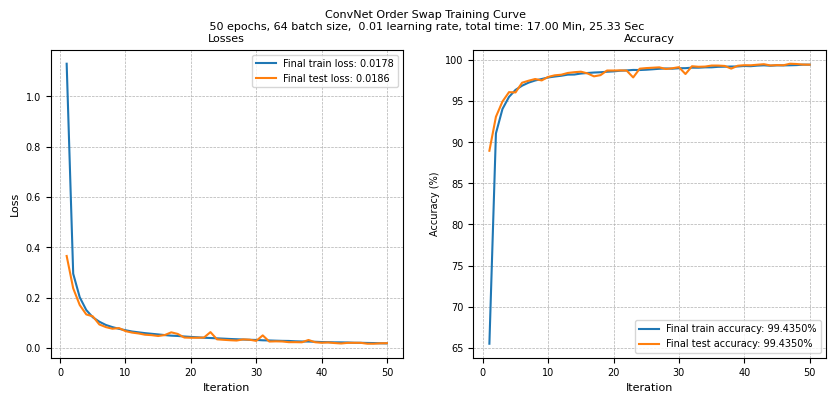

In [12]:
swap = mlconvnetorderwap().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(swap.parameters(), lr=learning_rate)
name = 'CNN Activation Swap'
models["cnnswap"] =train_network(swap, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)


Epoch 1/50, Train Loss: 1.1603, Test Loss: 0.4437, Train Accuracy: 70.8600%, Test Accuracy: 87.4533%
Epoch 2/50, Train Loss: 0.3688, Test Loss: 0.3181, Train Accuracy: 89.2267%, Test Accuracy: 90.6217%
Epoch 3/50, Train Loss: 0.2921, Test Loss: 0.2667, Train Accuracy: 91.3967%, Test Accuracy: 92.0883%
Epoch 4/50, Train Loss: 0.2500, Test Loss: 0.2316, Train Accuracy: 92.6133%, Test Accuracy: 93.0933%
Epoch 5/50, Train Loss: 0.2193, Test Loss: 0.2050, Train Accuracy: 93.4933%, Test Accuracy: 93.9033%
Epoch 6/50, Train Loss: 0.1946, Test Loss: 0.1825, Train Accuracy: 94.2283%, Test Accuracy: 94.6367%
Epoch 7/50, Train Loss: 0.1741, Test Loss: 0.1636, Train Accuracy: 94.8383%, Test Accuracy: 95.1983%
Epoch 8/50, Train Loss: 0.1567, Test Loss: 0.1476, Train Accuracy: 95.3567%, Test Accuracy: 95.6817%
Epoch 9/50, Train Loss: 0.1424, Test Loss: 0.1352, Train Accuracy: 95.8833%, Test Accuracy: 96.1200%
Epoch 10/50, Train Loss: 0.1301, Test Loss: 0.1237, Train Accuracy: 96.1933%, Test Accuracy

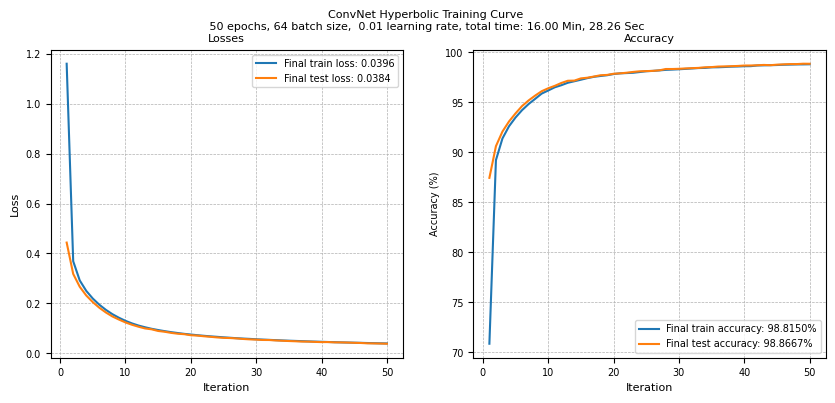

In [13]:
# b) Swap to hyperbolic instead of ReLU activations

class mlconvnethyperbolic(nn.Module):
    def __init__(self):
        super(mlconvnethyperbolic, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.Tanh()
        

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.Tanh()
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.Tanh()
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
    
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

hyperbolic = mlconvnethyperbolic().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(hyperbolic.parameters(), lr=learning_rate)
name = 'CNN tanh activation'
train_network(hyperbolic, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)

## 1.4 ADAM instead of SGD

Epoch 1/50, Train Loss: 0.1405, Test Loss: 0.0582, Train Accuracy: 96.4583%, Test Accuracy: 98.2750%
Epoch 2/50, Train Loss: 0.0639, Test Loss: 0.0441, Train Accuracy: 98.0683%, Test Accuracy: 98.5800%
Epoch 3/50, Train Loss: 0.0571, Test Loss: 0.0443, Train Accuracy: 98.2517%, Test Accuracy: 98.5817%
Epoch 4/50, Train Loss: 0.0558, Test Loss: 0.0383, Train Accuracy: 98.2800%, Test Accuracy: 98.8250%
Epoch 5/50, Train Loss: 0.0577, Test Loss: 0.0398, Train Accuracy: 98.2917%, Test Accuracy: 98.7100%
Epoch 6/50, Train Loss: 0.0535, Test Loss: 0.0409, Train Accuracy: 98.3633%, Test Accuracy: 98.7200%
Epoch 7/50, Train Loss: 0.0520, Test Loss: 0.0514, Train Accuracy: 98.4283%, Test Accuracy: 98.3333%
Epoch 8/50, Train Loss: 0.0522, Test Loss: 0.0331, Train Accuracy: 98.4633%, Test Accuracy: 98.9450%
Epoch 9/50, Train Loss: 0.0518, Test Loss: 0.0377, Train Accuracy: 98.4900%, Test Accuracy: 98.8200%
Epoch 10/50, Train Loss: 0.0530, Test Loss: 0.0360, Train Accuracy: 98.4883%, Test Accuracy

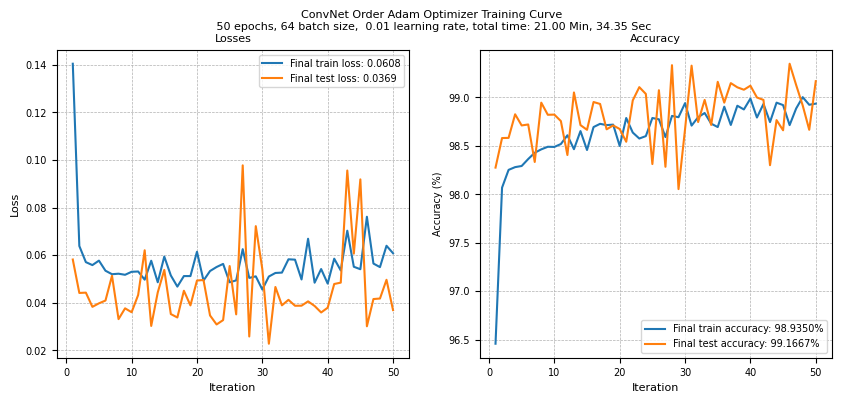

In [14]:
adam_optim = torch.optim.Adam(swap.parameters(), lr=learning_rate)
adam = 'CNN ADAM'
train_network(convenet, criteria, adam_optim, num_epochs, train_loader_3d, test_loader_3d, device, adam, learning_rate)


## 1.5 CNN three variants
Base model Architecture
 - Conv 8x3x3x1 stride 1 padding 1
 - Relu
 - Pool 

 - Conv 16x3x3x8 stride 1 padding 1
 - Relu
 - Pool

 - Conv 32x3x3x16 stride 1 padding 1
 - Relu
 - FC 32x7x7 in, 10 out

 Optimizer: SGD
 Loss : Cross Entropy
 Batch size: 64
 Epochs : 50
 
Variants: i: Nesterov acceleration, ii: L2 regularization, iii: Dropout layer after last convolution before full connected

#### 1.5 i Nesterov acceleration



In [28]:
modeli = mlconvnet()
optimizer = torch.optim.SGD(modeli.parameters(), lr=learning_rate, nesterov = True, momentum = 0.9)

models["nesterov"] = train_network(modeli, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, 'CNN Nesterov', learning_rate)

Epoch 1/50, Train Loss: 0.4023, Test Loss: 0.0963, Train Accuracy: 86.9883%, Test Accuracy: 96.9700%
Epoch 2/50, Train Loss: 0.0806, Test Loss: 0.0593, Train Accuracy: 97.5800%, Test Accuracy: 98.2333%
Epoch 3/50, Train Loss: 0.0572, Test Loss: 0.0449, Train Accuracy: 98.2383%, Test Accuracy: 98.6083%
Epoch 4/50, Train Loss: 0.0475, Test Loss: 0.0383, Train Accuracy: 98.5117%, Test Accuracy: 98.8433%
Epoch 5/50, Train Loss: 0.0409, Test Loss: 0.0322, Train Accuracy: 98.6983%, Test Accuracy: 98.9600%
Epoch 6/50, Train Loss: 0.0343, Test Loss: 0.0286, Train Accuracy: 98.9100%, Test Accuracy: 99.0833%
Epoch 7/50, Train Loss: 0.0304, Test Loss: 0.0229, Train Accuracy: 99.0367%, Test Accuracy: 99.2833%
Epoch 8/50, Train Loss: 0.0277, Test Loss: 0.0278, Train Accuracy: 99.1033%, Test Accuracy: 99.0967%
Epoch 9/50, Train Loss: 0.0243, Test Loss: 0.0204, Train Accuracy: 99.2050%, Test Accuracy: 99.3867%
Epoch 10/50, Train Loss: 0.0210, Test Loss: 0.0273, Train Accuracy: 99.3133%, Test Accuracy

1.5 ii L2 regularization

In [31]:
modelii = mlconvnet()
optimizer = torch.optim.SGD(modelii.parameters(), lr=learning_rate, weight_decay = 1e-4)
models["L2"] = train_network(modelii, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, 'CNN L2', learning_rate)

Epoch 1/50, Train Loss: 1.1660, Test Loss: 0.4559, Train Accuracy: 65.6867%, Test Accuracy: 85.3633%
Epoch 2/50, Train Loss: 0.3031, Test Loss: 0.2753, Train Accuracy: 90.6533%, Test Accuracy: 91.2667%
Epoch 3/50, Train Loss: 0.2118, Test Loss: 0.2080, Train Accuracy: 93.5067%, Test Accuracy: 93.5567%
Epoch 4/50, Train Loss: 0.1593, Test Loss: 0.1342, Train Accuracy: 95.1867%, Test Accuracy: 95.9967%
Epoch 5/50, Train Loss: 0.1269, Test Loss: 0.1307, Train Accuracy: 96.1983%, Test Accuracy: 96.0467%
Epoch 6/50, Train Loss: 0.1053, Test Loss: 0.0917, Train Accuracy: 96.8500%, Test Accuracy: 97.2717%
Epoch 7/50, Train Loss: 0.0907, Test Loss: 0.0872, Train Accuracy: 97.2467%, Test Accuracy: 97.3283%
Epoch 8/50, Train Loss: 0.0808, Test Loss: 0.0779, Train Accuracy: 97.5500%, Test Accuracy: 97.5967%
Epoch 9/50, Train Loss: 0.0741, Test Loss: 0.0710, Train Accuracy: 97.7067%, Test Accuracy: 97.7950%
Epoch 10/50, Train Loss: 0.0677, Test Loss: 0.0705, Train Accuracy: 97.9517%, Test Accuracy

In [32]:
class cnn_drop(nn.Module):
    def __init__(self):
        super(cnn_drop, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.drop(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

In [33]:
modeliii = cnn_drop()
optimizer = torch.optim.SGD(modeliii.parameters(), lr=learning_rate)
models["dropout"] = train_network(modeliii, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, 'CNN Dropout', learning_rate)

Epoch 1/50, Train Loss: 1.3326, Test Loss: 0.3817, Train Accuracy: 59.3967%, Test Accuracy: 88.3683%
Epoch 2/50, Train Loss: 0.3085, Test Loss: 0.2275, Train Accuracy: 90.5700%, Test Accuracy: 92.7367%
Epoch 3/50, Train Loss: 0.2023, Test Loss: 0.1630, Train Accuracy: 93.8833%, Test Accuracy: 95.3633%
Epoch 4/50, Train Loss: 0.1567, Test Loss: 0.1393, Train Accuracy: 95.3083%, Test Accuracy: 96.0367%
Epoch 5/50, Train Loss: 0.1308, Test Loss: 0.1033, Train Accuracy: 95.9883%, Test Accuracy: 96.9633%
Epoch 6/50, Train Loss: 0.1157, Test Loss: 0.0939, Train Accuracy: 96.4883%, Test Accuracy: 97.2083%
Epoch 7/50, Train Loss: 0.1040, Test Loss: 0.0793, Train Accuracy: 96.7883%, Test Accuracy: 97.5583%
Epoch 8/50, Train Loss: 0.0956, Test Loss: 0.0770, Train Accuracy: 97.0950%, Test Accuracy: 97.5783%
Epoch 9/50, Train Loss: 0.0882, Test Loss: 0.0752, Train Accuracy: 97.2517%, Test Accuracy: 97.6483%
Epoch 10/50, Train Loss: 0.0826, Test Loss: 0.0641, Train Accuracy: 97.3833%, Test Accuracy

#### Plot the test loss and accuracy of the models


In [52]:
for x,y in enumerate(models.keys()):
    print(x)
    print(y)
    print (round(models[y][2][-1],4))

0
nesterov
0.0001
1
L2
0.0165
2
dropout
0.0201


In [60]:

def compare_models(models: dict, title: str) -> None:
    # Test losses on index 2, test accuracy on index 4
    lg=13
    md=8
    sm=7
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=md)
    for x,y in enumerate(models.keys()):
        x = range(1, len(models[y][2])+1)
        axs[0].plot(x, models[y][2], label=f'Final test loss for {y}: {round(models[y][2][-1],4)}')
        axs[0].set_title('Losses', fontsize=md)
        axs[0].set_xlabel('Iteration', fontsize=md)
        axs[0].set_ylabel('Loss', fontsize=md)
        axs[0].legend(fontsize=sm)
        axs[0].tick_params(axis='both', labelsize=sm)
        # Optionally use a logarithmic y-scale
        #axs[0].set_yscale('log')
        axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
        axs[1].plot(x, models[y][4], label=f'Final test accuracy for {y}: {round(models[y][4][-1],4)}%')
        axs[1].set_title('Accuracy', fontsize=md)
        axs[1].set_xlabel('Iteration', fontsize=md)
        axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
        axs[1].legend(fontsize=sm)
        axs[1].tick_params(axis='both', labelsize=sm)
        axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

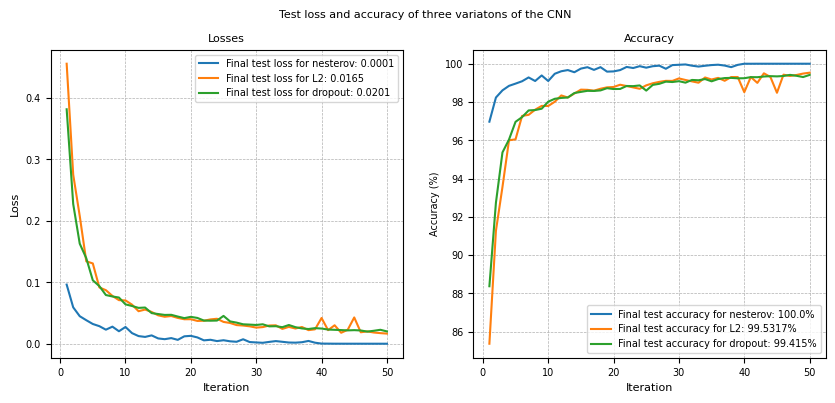

In [64]:
compare_models(models, "Test loss and accuracy of three variatons of the CNN")

### Confusion Matrix of best performing model & Missclassifications of 10 images


In [ ]:
# PLACEHOLDER